In [2]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.decomposition import FactorAnalysis


In [3]:
#build toy dataset
def generate_samples_gauss(n_samples_class):
    cov = np.array([[10, 2], [2, 1]])
    mean1 = np.array([0, 0])
    mean2 = np.array([0, 5])

    total_n_samples = n_samples_class*2
    x =  np.zeros((total_n_samples, 2))

    x[:n_samples_class, 0], x[:n_samples_class, 1] = np.random.multivariate_normal(mean1, cov, n_samples_class).T
    x[n_samples_class:, 0], x[n_samples_class:, 1]  = np.random.multivariate_normal(mean2, cov, n_samples_class).T

    labels = np.zeros(total_n_samples)
    labels[n_samples_class:] = 1
    return x, labels

In [4]:
def generate_samples_uniform(n_samples_class):
    x[:,0] = np.random.rand(2*n_samples_class)
    x[n_samples_class:,1] = x[n_samples_class:,0] + 0.1
    x[:n_samples_class,1] = x[:n_samples_class,0] - 0.1
    
    labels = np.zeros(2*n_samples_class)
    labels[n_samples_class:] = 1
    return x, labels


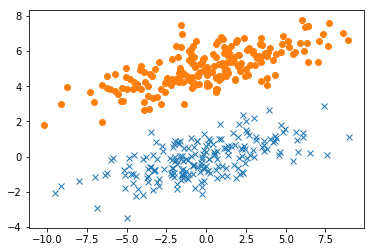

In [5]:
n_samples_class = 200
x, y  =  generate_samples_gauss(n_samples_class)
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')

#plt.savefig("data_2d.png")
plt.show()

In [78]:
latent_dim = 1 #suppose z is scalar
x_dim = 2      
opt = "ppca"
params_size_logit_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim + 1
params_size_norm_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim
params_size_logit_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim + 1
params_size_norm_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim 

if (opt == "fa"):
    params_size = params_size_logit_fa
else:
    params_size = params_size_logit_ppca
    


In [79]:
params = np.random.rand(params_size)

size_f = latent_dim*x_dim
var_init = params[size_f+x_dim:size_f+x_dim*2]

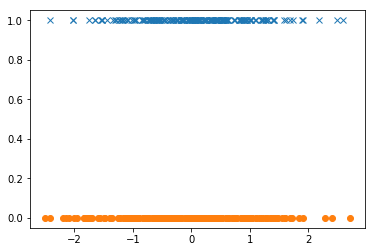

In [80]:
transformer = FactorAnalysis(n_components=1, random_state=0, noise_variance_init = var_init)
#transformer = FactorAnalysis(n_components=1, random_state=0)
x_proj_fa_python = transformer.fit_transform(x)
f_fa_python = transformer.components_
plt.plot(x_proj_fa_python[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_fa_python[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.savefig('data_proj_fa_python')
plt.show()

In [81]:
transformer.loglike_

[-2984.0356979462035,
 -2025.7582152951538,
 -2019.6002973934292,
 -2019.5901391475345,
 -2019.5901262346624]

In [82]:
f_fa = transformer.components_.T
cov_noise_fa= np.diag(transformer.noise_variance_)
bias_fa = np.mean(x, axis =0)

def compute_ll(f,bias,cov_noise, x):
    N = x.shape[0]
    D = x.shape[1]
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    ll = N*D*np.log(2*np.pi)/2
    ll += log_det_cov_x*N/2
    ll += np.sum(np.einsum("nd,dn->n", x - bias, temp1))/2
    return -ll

compute_ll(f_fa, bias_fa, cov_noise_fa, x)

-2019.5901262351363

In [20]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def objective_logit (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias_x, temp1)
    
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    ll = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior
    return ll 


def objective_norm (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    sigma = 1 # variance for the noise in y
    N = x.shape[0]
    D = x.shape[1]
    f, bias, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.einsum("dl,dm->lm", f, np.linalg.solve(cov_x,f)) #in fact m=l <- latent dimension 
    cov_z = np.identity(latent_dim) - temp1

    var_y = np.dot(w,np.dot(cov_z,w)) + sigma**2
    
    ll = N*D*np.log(2*np.pi)/2+(log_det_cov_x + lambda_e*np.log(var_y))*N*0.5
    
    temp2 = np.linalg.solve(cov_x, (x - bias).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias, temp2)
    mean_z = np.einsum("dl,dn->nl", f, temp2)
    mean_y = np.einsum("l,nl->n", w, mean_z)
    unnorm_log_pdf_y = (y - mean_y)**2/var_y
    ll = ll + 0.5*(np.sum(unnorm_log_pdf_x) + lambda_e*np.sum(unnorm_log_pdf_y))
    
    log_prior = 0 #f,bias,cov_noise and m for regularization use gaussian priors later
    ll = ll - log_prior
    return ll

def decode_parameters(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        cov_noise= np.diag(np.ones(D)*np.log(1+np.exp(var)))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise= np.diag(np.log(1+np.exp(var)))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w

def transform(f, bias, cov_noise, x):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp = np.linalg.solve(cov_x, (x - bias).T)
    mean_z = np.einsum("dl,dn->nl", f, temp)
    return mean_z

In [83]:
f, bias, cov_noise, w =  decode_parameters(params, x_dim, latent_dim, opt)
print "Initial parameters"
print "F:", f
print "slope", f[1]/f[0]
print "bias: ", bias
print "cov_noise matrix: ", cov_noise
print "regression weights: ", w
print "initial obj value logit", objective_logit(params, x, y, latent_dim, 0, opt)
#print "initial obj value norm", objective_norm(params, x, y, latent_dim, 0, opt)
print compute_ll (f,bias,cov_noise,x)

Initial parameters
F: [[0.9933116 ]
 [0.22860939]]
slope [0.23014872]
bias:  [0.69125653 0.39666935]
cov_noise matrix:  [[1.11116114 0.        ]
 [0.         1.11116114]]
regression weights:  [0.81961054 0.03998707]
initial obj value logit 4187.611371867668
-4187.611371867668


In [90]:
lambda_e = 10
#run minimizer use ADAM instead?
def pcallback(params):
    f, bias, cov_noise, w = decode_parameters(params, x_dim, latent_dim, opt)
    print compute_ll(f, bias, cov_noise, x)
    
grad_objective_logit = grad(objective_logit, argnum = 0)
params_optimizied_logit, obj_value_logit, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_e, opt), callback= pcallback, pgtol = 1e-2)
f_logit, bias_logit, cov_noise_logit, w_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, opt)
print "Final parameters_logit"
print "logit slope\n", f_logit[1]/f_logit[0]
print "F:\n", f_logit
print "bias for x:\n", bias_logit
print "cov_noise matrix:\n", cov_noise_logit
print "bias for y:\n", w_logit[0]
print "logistic regression weights:\n", w_logit[1:]
print "final objective value:\n", obj_value_logit

-3040.1740998690057
-2438.0939368186278
-2201.7708871253058
-2224.229776363811
-2212.6945558681173
-2211.091829569672
-2191.772389519079
-2168.6773132419826
-2107.8328716351275
-2097.5868188956306
-2084.839497928744
-2080.9008019908388
-2080.2473654594746
-2075.270138366107
-2072.9124844769754
-2069.865554391427
-2064.9028130092074
-2056.3794555278473
-2053.4086095983253
-2053.590433323437
-2054.55469638656
-2054.2009842576517
-2051.035464161005
-2049.1903881113526
-2049.5200470624873
-2048.9432001203245
-2048.706315489543
-2048.6466025283626
-2048.4396214808885
-2048.391420617344
-2048.2046080145196
-2048.2116800534927
-2048.1138791278513
-2048.034750041983
-2047.9576672529583
-2047.8862705032766
-2047.8914455562513
-2047.7985291078967
-2047.7451743955348
-2047.6672079278762
-2047.659663488827
-2047.6201008176502
-2047.6042773312545
-2047.6058212700975
-2047.5754272879099
-2047.5505915366439
-2047.5331544812702
-2047.5296062174657
-2047.5193702275005
-2047.518054805621
-2047.513264421

In [44]:
print "F scikit-learn\n", f_fa 
print "mean of x scikit-learn\n", bias_fa
print "cov noise scikit-learn\n", cov_noise_fa


F scikit-learn
[[-3.30753853]
 [-0.88275735]]
mean of x scikit-learn
[-0.11026254  2.45706159]
cov noise scikit-learn
[[0.71663358 0.        ]
 [0.         7.09638426]]


In [88]:
print (np.einsum("dl,ml->dm",f_fa,f_fa) + cov_noise_fa)
print (np.einsum("dl,ml->dm",f_logit,f_logit) + cov_noise_logit)

[[11.65644444  2.91975511]
 [ 2.91975511  7.87572189]]
[[11.65754931  2.92002295]
 [ 2.92002295  7.87565921]]


In [68]:
grad_objective_norm = grad(objective_norm, argnum = 0)
params_optimizied_norm, obj_value_norm, dict = fmin_l_bfgs_b(objective_norm, x0 = params, fprime = grad_objective_norm, args = (x, y, latent_dim, lambda_e, opt), callback= pcallback, pgtol = 1e-2)
f_norm, bias_norm, cov_noise_norm, w_norm = decode_parameters(params_optimizied_norm, x_dim, latent_dim, opt)
print "Final parameters_norm"
print "norm slope\n", f_norm[1]/f_norm[0]
print "F:\n", f_norm
print "mean:\n ", bias_norm
print "cov_noise matrix:\n", cov_noise_norm
print "regression weights:\n", w_norm
print "final objective value:\n", obj_value_norm
print dict


ValueError: shapes (1,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)

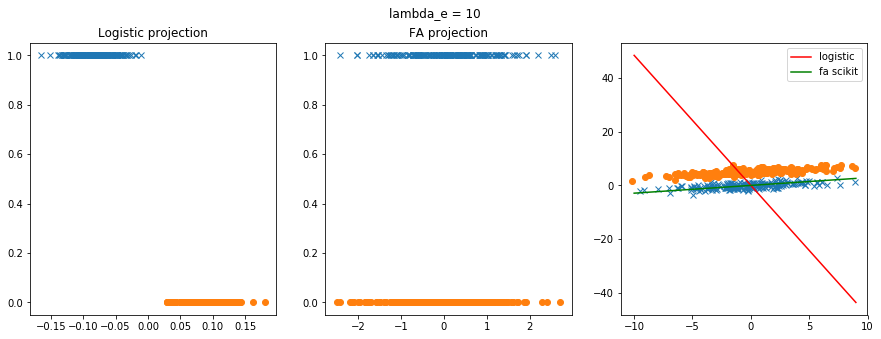

In [91]:
plt.figure(figsize=(15,5))

plt.subplot(131) 
plt.suptitle("lambda_e = {}".format(lambda_e))

plt.title("Logistic projection")
x_proj_logit = transform(f_logit, bias_logit, cov_noise_logit, x)
plt.plot(x_proj_logit[:n_samples_class], np.ones(n_samples_class), 'x')
plt.plot(x_proj_logit[n_samples_class:], np.zeros(n_samples_class), 'o')

plt.subplot(132) 
plt.title("FA projection")
x_proj_fa_python = transform(f_fa, bias_fa, cov_noise_fa, x)

plt.plot(x_proj_fa_python[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_fa_python[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.subplot(133) 
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')
a = np.array(range(int(round(np.min(x[:,0]))), 1+int(round(np.max(x[:,0]))))) 
b_pc_fa_logit = f_logit[1]/f_logit[0]*a 
#b_pc_fa_norm = f_norm[1]/f_norm[0]*a 

b_std_fa = f_fa[1]/f_fa[0]*a

plt.plot(a, b_pc_fa_logit,  color ="r", label='logistic')
#plt.plot(a, b_pc_fa_norm,  color ="b", label='normal')
plt.plot(a, b_std_fa, color ="g", label='fa scikit')
plt.legend()

plt.savefig("data_lambda_e={}_logistic_norm.png".format(lambda_e))
plt.show()

In [71]:
from sklearn.linear_model import LogisticRegression
clf_fa = LogisticRegression().fit(x_proj_fa_python, y)
clf_fa.score(x_proj_fa_python, y)

0.5475

In [92]:
clf_pc = LogisticRegression().fit(x_proj_logit, y)
clf_pc.score(x_proj_logit, y)

1.0

In [93]:
clf = LogisticRegression().fit(x, y)
clf.score(x, y)

1.0